Analyses on the output data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Load data and extract domain prefixes

In [2]:
# Load the cleaned dataset
cleaned_dataset_path = "../output/cleaned_merged_dataset.csv"
data = pd.read_csv(cleaned_dataset_path)

# Extract domain prefixes and their associated columns
domains = {
    "molec": [col for col in data.columns if col.startswith("molec_")],
    "subin": [col for col in data.columns if col.startswith("subin_")],
    "indiv": [col for col in data.columns if col.startswith("indiv_")],
    "popul": [col for col in data.columns if col.startswith("popul_")],
    "commu": [col for col in data.columns if col.startswith("commu_")],
    "letha": [col for col in data.columns if col.startswith("letha_")],
}

Step 1: Count the number of papers marked as "Included" in each domain

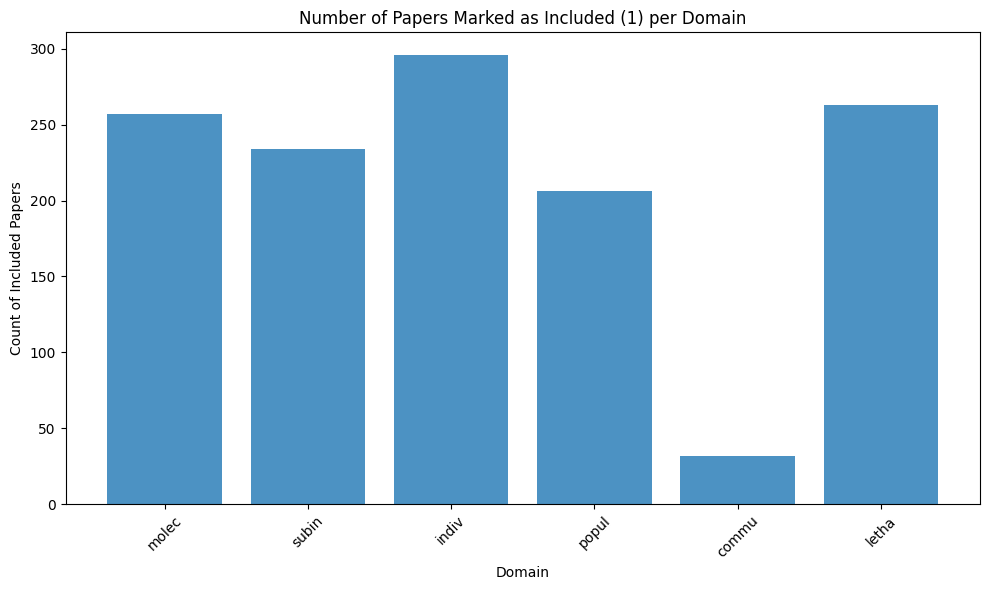

{'molec': np.int64(257), 'subin': np.int64(234), 'indiv': np.int64(296), 'popul': np.int64(206), 'commu': np.int64(32), 'letha': np.int64(263)}


In [3]:
domain_counts = {domain: (data[cols] == 1).any(axis=1).sum() for domain, cols in domains.items()}

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(domain_counts.keys(), domain_counts.values(), alpha=0.8)
plt.title("Number of Papers Marked as Included (1) per Domain")
plt.xlabel("Domain")
plt.ylabel("Count of Included Papers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(domain_counts)

Step 2: Calculate reviewer agreement within each domain

In [4]:
# Initialize a dictionary for reviewer pairwise agreement counts
pairwise_agreement_counts = {}

for domain, cols in domains.items():
    if len(cols) == 2:  # Domains with exactly 2 reviewers
        # Drop rows where either reviewer has NaN
        domain_data = data[cols].dropna()

        # Count agreements and disagreements between the two reviewers
        agree = (domain_data[cols[0]] == domain_data[cols[1]]).sum()
        disagree = len(domain_data) - agree

        # Store results for this domain
        pairwise_agreement_counts[domain] = {f"{cols[0]} vs {cols[1]}": {"Agreed": agree, "Disagreed": disagree}}

    elif len(cols) == 3:  # Domains with 3 reviewers
        # Pairwise comparison for 3 reviewers: (1 vs 2), (1 vs 3), (2 vs 3)
        pairwise_results = {}
        for i in range(len(cols)):
            for j in range(i + 1, len(cols)):
                # Drop rows where either reviewer in the pair has NaN
                domain_data = data[[cols[i], cols[j]]].dropna()

                # Count agreements and disagreements for this pair
                agree = (domain_data[cols[i]] == domain_data[cols[j]]).sum()
                disagree = len(domain_data) - agree

                # Store results for this pair
                pair_key = f"{cols[i]} vs {cols[j]}"
                pairwise_results[pair_key] = {"Agreed": agree, "Disagreed": disagree}

        # Store results for this domain
        pairwise_agreement_counts[domain] = pairwise_results

    elif len(cols) == 4:  # Lethal domain with 4 reviewers
        # Pairwise comparison for 4 reviewers: (1 vs 2), (1 vs 3), ..., (3 vs 4)
        pairwise_results = {}
        for i in range(len(cols)):
            for j in range(i + 1, len(cols)):
                # Drop rows where either reviewer in the pair has NaN
                domain_data = data[[cols[i], cols[j]]].dropna()

                # Count agreements and disagreements for this pair
                agree = (domain_data[cols[i]] == domain_data[cols[j]]).sum()
                disagree = len(domain_data) - agree

                # Store results for this pair
                pair_key = f"{cols[i]} vs {cols[j]}"
                pairwise_results[pair_key] = {"Agreed": agree, "Disagreed": disagree}

        # Store results for this domain
        pairwise_agreement_counts[domain] = pairwise_results

# Convert pairwise_agreement_counts into a more readable format
results = []
for domain, pairs in pairwise_agreement_counts.items():
    for pair, counts in pairs.items():
        total = counts["Agreed"] + counts["Disagreed"]
        proportion_agreed = counts["Agreed"] / total if total > 0 else 0
        results.append({
            "Domain": domain,
            "Reviewer Pair": pair,
            "Agreed": counts["Agreed"],
            "Disagreed": counts["Disagreed"],
            "Proportion Agreed": proportion_agreed
        })

pairwise_agreement_df = pd.DataFrame(results)

# Print the pairwise agreement table with proportion agreed
print("\nPairwise Reviewer Agreement with Proportion Agreed:")
print(pairwise_agreement_df)

# Save the results to a CSV file
pairwise_agreement_df.to_csv("pairwise_reviewer_agreement_with_proportion.csv", index=False)
print("\nPairwise reviewer agreement data saved to 'pairwise_reviewer_agreement_with_proportion.csv'")


Pairwise Reviewer Agreement with Proportion Agreed:
   Domain         Reviewer Pair  Agreed  Disagreed  Proportion Agreed
0   molec  molec_AH vs molec_AJ     241         66           0.785016
1   molec  molec_AH vs molec_EA     235         78           0.750799
2   molec  molec_AJ vs molec_EA     294        107           0.733167
3   subin  subin_RP vs subin_RT      72         28           0.720000
4   indiv  indiv_AB vs indiv_RP      75         21           0.781250
5   popul  popul_CB vs popul_RP      19          4           0.826087
6   commu  commu_AB vs commu_RP      84         15           0.848485
7   letha  letha_ER vs letha_ES      37         10           0.787234
8   letha  letha_ER vs letha_NN     122         20           0.859155
9   letha  letha_ER vs letha_RP      48          2           0.960000
10  letha  letha_ES vs letha_NN      50          0           1.000000
11  letha  letha_ES vs letha_RP       0          1           0.000000
12  letha  letha_NN vs letha_RP      

Get average proportion agreed across domains

In [5]:
# Load the CSV file with the pairwise agreement data
csv_path = "pairwise_reviewer_agreement_with_proportion.csv"
agreement_data = pd.read_csv(csv_path)

# Calculate the average proportion agreed
average_proportion = agreement_data["Proportion Agreed"].mean()

# Print the result
print(f"Average Proportion Agreed: {average_proportion:.2f}")

Average Proportion Agreed: 0.77


Check to see how often papers were selected in more than one domain


Summary Table: Papers Marked Relevant in Multiple Domains
   Number of Relevant Domains  Paper Count
0                           0          186
1                           1          525
2                           2          270
3                           3           57
4                           4           13


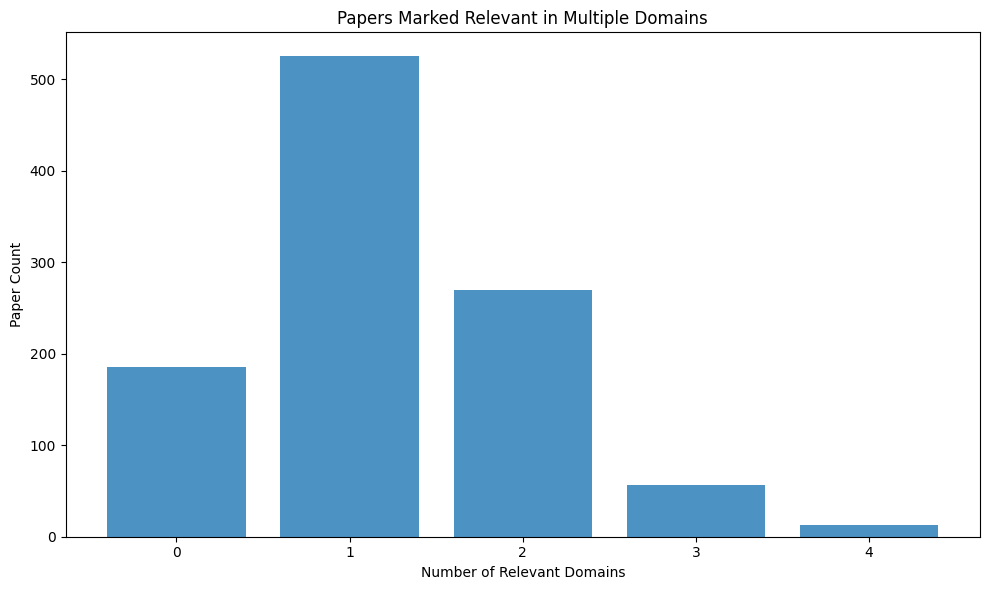

In [6]:
# Step 1: Summarize the relevant papers across domains
# Create a binary matrix where each domain has 1 if the paper is relevant in any column of that domain
relevant_by_domain = pd.DataFrame({
    domain: (data[cols] == 1).any(axis=1).astype(int) for domain, cols in domains.items()
})

# Add a column to count the number of domains each paper is marked as relevant
relevant_by_domain["Relevant_Domain_Count"] = relevant_by_domain.sum(axis=1)

# Step 2: Create a table summarizing the counts
relevant_summary = relevant_by_domain["Relevant_Domain_Count"].value_counts().sort_index()
relevant_summary_table = relevant_summary.reset_index()
relevant_summary_table.columns = ["Number of Relevant Domains", "Paper Count"]

# Display the summary table
print("\nSummary Table: Papers Marked Relevant in Multiple Domains")
print(relevant_summary_table)

# Step 3: Create a plot

plt.figure(figsize=(10, 6))
plt.bar(relevant_summary.index, relevant_summary.values, alpha=0.8)
plt.title("Papers Marked Relevant in Multiple Domains")
plt.xlabel("Number of Relevant Domains")
plt.ylabel("Paper Count")
plt.xticks(relevant_summary.index)
plt.tight_layout()
plt.show()

Co-occurrence matrix: which domains were selected together most often

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter papers marked relevant in 2 or more domains
filtered_data = relevant_by_domain[relevant_by_domain["Relevant_Domain_Count"] >= 2]

# Step 2: Calculate co-occurrences between domains
co_occurrence_matrix = filtered_data[domains.keys()].T.dot(filtered_data[domains.keys()])
co_occurrence_matrix = co_occurrence_matrix.astype(int)

# Convert matrix to a DataFrame for display
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=domains.keys(), columns=domains.keys())

# Step 3: Display co-occurrence matrix
print("\nCo-Occurrence Matrix: Relevant Papers Across Domains")
print(co_occurrence_df)

# Step 4: Visualize co-occurrences with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Co-Occurrence of Relevant Papers Between Domains")
plt.xlabel("Domain")
plt.ylabel("Domain")
plt.tight_layout()
plt.show()
